# Employee Performance Data Modelling and Prediction

## About
We try to predict and create inferences for employee performance scores based one a number fo

Setting up the notebook settings

In [0]:
!--NotebookApp.iopub_data_rate_limit=1e11

/bin/bash: --: invalid option
Usage:	/bin/bash [GNU long option] [option] ...
	/bin/bash [GNU long option] [option] script-file ...
GNU long options:
	--debug
	--debugger
	--dump-po-strings
	--dump-strings
	--help
	--init-file
	--login
	--noediting
	--noprofile
	--norc
	--posix
	--rcfile
	--restricted
	--verbose
	--version
Shell options:
	-ilrsD or -c command or -O shopt_option		(invocation only)
	-abefhkmnptuvxBCHP or -o option


In [0]:
import warnings
warnings.filterwarnings('ignore') 

# Project Flow Overview

1. Load Data
2. Cursory Description of Data
3. EDA
4. Feature Selection/ Extraction
5. Modelling
6. Prediction
7. Optimization
8. Modelling
9. End Point
10. Conclusion and Discussion

# 1. Load Data

In [0]:
# Run this cell to mount your Google Drive.
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
# get colmumn names for main dataset with key from other dataset
import pandas as pd
pd.set_option('display.max_rows', 500)
import numpy as np

col_names = pd.read_csv("/content/drive/My Drive/sharpestminds_dataset/CodeBook-SELECT.csv")
col_names = col_names.loc[:, "VarName"].values

In [0]:
# load in the actual dataset
df = pd.read_csv("/content/drive/My Drive/sharpestminds_dataset/hw5-trainingset-cl3770.csv", header="infer")
df.head()

,cntryid,cntryid_e,age_r,gender_r,computerexperience,nativespeaker,edlevel3,monthlyincpr,yearlyincpr,lng_home,cnt_h,cnt_brth,reg_tl2,lng_bq,lng_ci,yrsqual,yrsqual_t,yrsget,vet,ctryqual,birthrgn,nativelang,ctryrgn,imyrs,imyrs_c,imyrcat,ageg5lfs,ageg10lfs,ageg10lfs_t,edcat8,edcat7,edcat6,leaver1624,leavedu,fe12,aetpop,faet12,faet12jr,faet12njr,nfe12,...,v253,v132,v284,v267,v260,v26,v171,v14,v7,v240,v186,v162,v149,v228,v28,v237,v280,v175,v288,v15,v208,v43,v27,v114,v191,v170,v65,v57,v177,v69,v85,v50,v89,v127,v239,v224,v71,v105,row,uni
0,Canada,Canada (English),NaN,Female,Yes,Yes,Medium,50 to less than 75,50 to less than 75,999,NaN,NaN,99999,eng,eng,12.0,12.0,14.0,False,NaN,NaN,Test language same as native language,North America and Western Europe,NaN,NaN,Non-immigrants,Aged 25-29,25-34,25-34,NaN,"Upper secondary (ISCED 3A-B, C long)","Upper secondary (ISCED 3A-B, C long)",NaN,NaN,Participated in FE,AET population,Participated in formal AET,Participated in formal AET for JR reasons,Did not participate in FE for NJR reasons,Did not participate in NFE,...,Never,Every day,At least once a week,Never,At least once a week but not every day,At least once a week,At least once a week but not every day,At least once a week but not every day,At least once a week but not every day,At least once a week but not every day,Never,Never,Less than once a week but at least once a month,NaN,Yes,Every day,Every day,At least once a week but not every day,Never,Less than once a week but at least once a month,Never,Never,To a high extent,To a very high extent,To a high extent,To some extent,To a high extent,To a very high extent,Never,Disagree,Neither agree nor disagree,Agree,NaN,NaN,9999.0,9996.0,9999,9999.0,80219,cl3770
1,United Kingdom,England (UK),60.0,Male,Yes,Yes,High,75 to less than 90,75 to less than 90,eng,NaN,United Kingdom of Great Britain and Northern I...,UKJ,eng,eng,15.0,15.0,NaN,NaN,NaN,North America and Western Europe,Test language same as native language,North America and Western Europe,NaN,NaN,Non-immigrants,Aged 60-65,55 plus,55 plus,Tertiary – professional degree (ISCED 5B),Tertiary – professional degree (ISCED 5B),Tertiary – professional degree (ISCED 5B),NaN,21.0,Did not participate in FE,AET population,Did not participate in formal AET,Did not participate in formal AET for JR reasons,Did not participate in FE for NJR reasons,Participated in NFE,...,At least once a week,Every day,At least once a week,At least once a week but not every day,Less than once a month,Rarely,At least once a week but not every day,Less than once a month,Every day,Every day,Less than once a week but at least once a month,Less than once a month,Less than once a week but at least once a month,NaN,Yes,Every day,Every day,At least once a week but not every day,At least once a week but not every day,At least once a week but not every day,Less than once a month,Less than once a month,To a high extent,To a high extent,To a high extent,To a high extent,To a high extent,To a very high extent,Never,Agree,Strongly agree,Agree,NaN,NaN,3118.0,9996.0,2520,9996.0,44314,cl3770
2,United Kingdom,England (UK),31.0,Male,Yes,Yes,High,75 to less than 90,75 to less than 90,eng,NaN,United Kingdom of Great Britain and Northern I...,UKI,eng,eng,16.0,16.0,NaN,NaN,NaN,North America and Western Europe,Test language same as native language,North America and Western Europe,NaN,NaN,Non-immigrants,Aged 30-34,25-34,25-34,Tertiary - bachelor/master/research degree (IS...,Tertiary - bachelor/master/research degree (IS...,Tertiary - bachelor/master/research degree (IS...,NaN,NaN,Participated in FE,AET population,Participated in formal AET,Participated in formal AET for JR reasons,Did not participate in FE for NJR reasons,Participated in NFE,...,At least once a week,Less than once a week but at least once a month,Less than once a week but at least once a month,Less than once a month,Less than once a month,Rarely,Less than once a month,At least once a week but not every day,At least once a week but

### The dataset is a 93Mb csv file

In [0]:
!du -hs "/content/drive/My Drive/sharpestminds_dataset/hw5-trainingset-cl3770.csv"

93M	/content/drive/My Drive/sharpestminds_dataset/hw5-trainingset-cl3770.csv


In [0]:
# we have a lot of data here
print("{} features, {} observations".format(df.shape[1], df.shape[0]))

# we also have a lot of non-numeric data as well
print(df.info())

print(df.describe())

380 features, 20000 observations
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Columns: 380 entries, cntryid to uni
dtypes: float64(80), int64(5), object(295)
memory usage: 58.0+ MB
None
              age_r       yrsqual  ...          v105            row
count  12118.000000  17417.000000  ...  19979.000000   20000.000000
mean      39.339412     14.573549  ...   9833.138696   96825.751700
std       11.004673      2.703482  ...   1009.110938   57590.955791
min       16.000000      5.000000  ...     31.000000      98.000000
25%       31.000000     12.000000  ...   9996.000000   46369.000000
50%       38.000000     15.000000  ...   9996.000000   94729.000000
75%       48.000000     16.000000  ...   9996.000000  147668.500000
max       65.000000     22.000000  ...   9999.000000  197786.000000

[8 rows x 85 columns]


# 3. EDA - Missing Values

### We print out the the counts of observations with missing values in this dataset

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# There are a lot of missing values in this dataset
print(df.isnull().sum().sort_values(ascending=False)[df.isnull().sum() > 1000][:25])

v262    20000
v44     19997
v76     19993
v144    19992
v199    19991
v159    19985
v10     19981
v172    19977
v110    19956
v160    19955
v100    19955
v109    19954
v75     19938
v211    19938
v215    19936
v163    19935
v220    19927
v254    19923
v38     19910
v129    19910
v266    19907
v89     19864
v127    19828
v117    19793
v287    19792
dtype: int64


## Missing Data Proportion by Columns
We will want to drop a number of the columns have have a significant amount of its data missing. Some features have disproportionately more data missing than others and there will be no way to impute those features. In which case dropping those features might be the best course of action to clean up the dataset. Feature column values that have a proportion of their data missing equal to or greater than an arbitrary threshold will have their columns dropped. Afterwards, a row-wise operation of this procedure will be further applied to include cleaner samples in the dataset. 
________________

We will examine to see which features reach this threshold requirement to be dropped before we do any such dropping. 
____________ 

Afterwards, we will want to smarly impute the remaining missing data points as much as we can.

In [0]:
# features by % of missing data
dropthreshold = 60

pct_missing_list = np.array([col for col in df.columns if df[col].isnull().sum()/df.shape[0] * 100 >= dropthreshold])
pm_list = []


for col in df.columns:
    if df[col].isnull().sum()/df.shape[0] * 100 >= dropthreshold:
        pm_list.append(df[col].isnull().sum()/df.shape[0] * 100)
        
missing_data_series = pd.DataFrame(pm_list, columns=['% Missing Data'], index=pct_missing_list).sort_values(by='% Missing Data', ascending=False)

# save the results to csv to look at later
missing_data_series.to_csv('./features_greater_60_percent_missing_data_by_cols.csv')

## Missing Data Proportion By Row 
An alternative strategy would be just to drop all of the rows with missing values. This step requires a little more wor as we will have more than 0 data points that have missing values and require imputation of missing values.


Lets first drop any data ROWS with 50% or more missing values and see what we end up with.

________________


Just a refresher on how to how to conditionally select rows from a data frame:

To select rows whose column value equals a scalar, some_value, use ==:
df.loc[df['column_name'] == some_value]


To select rows whose column value is in an iterable, some_values, use isin:
df.loc[df['column_name'].isin(some_values)]

Combine multiple conditions with &:
df.loc[(df['column_name'] >= A) & (df['column_name'] <= B)]





In [0]:
# Data points with percentage of data missing and greater will be dropped from the dataset
dropthreshold = 40

# get the data points in the dataframe that have >= 30% of their data missing
df_row_gtoe_30_missing = df.loc[(df.isnull().sum(axis=1)/df.shape[1]*100 >= dropthreshold)]
reduced_row_gtoe_30_missing = df.loc[(df.isnull().sum(axis=1)/df.shape[1]*100 <= dropthreshold)]

print("The data points with {}% or more of it's data missing will be dropped from the dataset.".format(dropthreshold))
print("The size of the dataset has been reduced by {0:.2f}% after dropping the rows with a significant amount of missing data.".format(df_row_gtoe_30_missing.shape[0]/df.shape[0] * 100))
print("The size of the dataset remaining after the missing data points have been dropped {0:.2f}%.".format(reduced_row_gtoe_30_missing.shape[0]/df.shape[0] * 100))
print("This is the size of the dataset before it was reduced: {}".format(df.shape))
print("The shape of the data that would be dropped with >= 30% of its data missing : {}".format(df_row_gtoe_30_missing.shape))
print("This is the shape of the remaining dataset, after having dropped the data points with GTOE 30% of the data missing: {}".format(reduced_row_gtoe_30_missing.shape))

The data points with 40% or more of it's data missing will be dropped from the dataset
The size of the dataset has been reduced by 27.46% after dropping the rows with a significant amount of missing data.
The size of the dataset remaining after the missing data points have been dropped 73.22%.
This is the size of the dataset before it was reduced: (20000, 380)
The shape of the data that would be dropped with >= 30% of its data missing : (5491, 380)
This is the shape of the remaining dataset, after having dropped the data points with GTOE 30% of the data missing: (14644, 380)


## Missing Data by Data Type
We can see that there are a considerable amount of missing values for this dataset. We will have to dig in to understand which features would have missing values, and can we come up with a strategy to handle it.

In [0]:
# separate out the numeric and categorical variables to see how much of each are missing

numeric_df = df._get_numeric_data() # 85 numeric features
categorical_df = df.select_dtypes(exclude = [int, float]) # 380-84 = 296 text/categorical features

print("Shape of Numeric Feature DF: {}".format(numeric_df.shape))
print("Shape of Non-Numeric Feature DF: {}".format(categorical_df.shape))

Shape of Numeric Feature DF: (20000, 85)
Shape of Non-Numeric Feature DF: (20000, 295)


## Impressions on missing categorical data

There are some categorical feature values that use numeric values as either a range, or an indicator for a missing value. Some of these features include:
* reg_tl2
* lng_home
* ageg10lfs 
* ageg10lfs_t 


In [0]:
# How much of each feature-type is missing?
print("MISSING VALUES OF NUMERIC FEATURES")
print(numeric_df.isnull().sum().sort_values(ascending=False)[:10])

print("\n#######################################\n\
#######################################\n\
#######################################\n")

print("MISSING VALUES OF NON-NUMERIC FEATURES")
print(categorical_df.isnull().sum().sort_values(ascending=False)[:10])

MISSING VALUES OF NUMERIC FEATURES
v262    20000
v110    19956
v160    19955
v100    19955
v215    19936
v163    19935
v129    19910
v45     19661
v268    19658
v113    19458
dtype: int64

#######################################
#######################################
#######################################

MISSING VALUES OF NON-NUMERIC FEATURES
v44     19997
v76     19993
v144    19992
v199    19991
v159    19985
v10     19981
v172    19977
v109    19954
v75     19938
v211    19938
dtype: int64


### Just to get a little perspective on how many categories there are for the dataset, we will print each of their unique values for the first several features

In [0]:
# unique values for each categorical feature. need to know how what encoding scheme we should use
for column in categorical_df.columns[:11]:
    print(f"######### {column} ##########")
    print(categorical_df[column].unique())
    print("Number of unique values: {}\n".format(len(categorical_df[column].unique())))

######### cntryid ##########
['Canada' 'United Kingdom' 'Norway' 'United States' 'Russian Federation'
 'Turkey' 'Sweden' 'Germany' 'Korea' 'Ireland' 'Singapore' 'Italy'
 'Poland' 'France' 'Japan' 'Netherlands' 'Chile' 'Spain' 'Slovenia'
 'Denmark' 'Belgium' 'Slovak Republic' 'Israel' 'Czech Republic' 'Estonia'
 'Greece' 'Finland' 'Austria' 'New Zealand' 'Lithuania']
Number of unique values: 30

######### cntryid_e ##########
['Canada (English)' 'England (UK)' 'Norway' 'United States'
 'Russian Federation' 'Turkey' 'Sweden' 'Germany' 'Korea' 'Ireland'
 'Singapore' 'Italy' 'Poland' 'France' 'Japan' 'Netherlands' 'Chile'
 'Spain' 'Slovenia' 'Denmark' 'Canada (French)' 'Flanders (Belgium)'
 'Slovak Republic' 'Israel' 'Northern Ireland (UK)' 'Czech Republic'
 'Estonia' 'Greece' 'Finland' 'Austria' 'New Zealand' 'Lithuania' nan]
Number of unique values: 33

######### gender_r ##########
['Female' 'Male']
Number of unique values: 2

######### computerexperience ##########
['Yes' 'No' nan]
Num

### As we can see, there are a lot of unique categorical values for each cateorical feature. One hot encoding this data set would balloon it quite a bit... We will have to strategically drop our data first before we encode our feature values.

# Overall impressions on missing data


*   There are no missing values for the class variable : "job performance"
*   There are more missing values for numeric features than non-numeric features
*  Can we build a model with only features that are that have completed values?
* Can we build a model with only features that are only partially complete?



# Handling Missing Values - Drop Step

Before even deciding on what encoding scheme, we should apply to our data, we have a sense of how much of the data is missing. Now is the time to determine which feature columns must be dropped, due to a large proportion of the data data being missing.

# Imputation for Missing Values
We want to then use an informed approach to imputation of missing data values. One method could be the use of random forest and proximity matrix to imputing the missing values for our dataset with some similarity metric

# Dev Branch 1 - Encoding the Categorical Variables

We pick an encoding scheme to create dummy encoded categorical variables from our large array of categorical variables

In [0]:
# Here, we choose to choose a simple one-hot encoding scheme for our features
from sklearn.preprocessing import LabelEncoder
enc = LabelEncoder()
enc.fit(np.array(drop_null_missing_df))
encoded_df = enc.transform(drop_null_missing_df)
print(encoded_df(5))

ValueError: ignored

In [0]:
# frequency numeric distribution of features 
feature_labels = [i for i in drop_null_missing_df.columns if i != "job_performance"]

for i in feature_labels:
    print("###### {} ######\n".format(i))
    print(drop_null_missing_df[i].value_counts())
    print("\n")

###### cntryid ######

United States         4061
Germany               2061
Japan                 1711
Canada                1274
Russian Federation    1210
Korea                 1169
United Kingdom        1169
France                1130
Spain                  891
Italy                  806
Poland                 768
Turkey                 537
Netherlands            411
Czech Republic         389
Chile                  344
Greece                 208
Finland                207
Austria                186
Slovak Republic        184
Israel                 178
Singapore              156
Sweden                 148
New Zealand            144
Belgium                143
Denmark                134
Ireland                112
Norway                  89
Lithuania               70
Slovenia                67
Estonia                 43
Name: cntryid, dtype: int64


###### gender_r ######

Male      12495
Female     7505
Name: gender_r, dtype: int64


###### lng_bq ######

eng    6718
deu    2247
jpn 

## Notes from visualization of the value_counts of the features

### Missing/NA/Unknown Values encoded as someting different in features

lng_bq: 999

995, 9996, 9997, 9998, 9999 seem to be a similar encoding value for each of the isco_c features.

Without domain knowledge and context of these variable encodings, dropping these encodings maybe an irresponsible thing to do. However, we may considering dropping rows with these values.

# Dev Branch 1 - Data Visualization for EDA

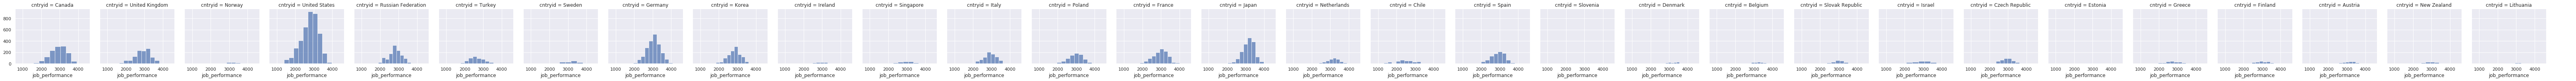

In [0]:
# Here, we plot the several categorical variables of interest against the job performance metric to visualize the distribution of job performance among the categories
# Make the plots a little bigger
sns.set(rc={'figure.figsize':(11.7,8.27)})

feature_labels = [i for i in drop_null_missing_df.columns if i != "job_performance"]

# create a FacetGrib object, on which to map your dataframe data onto
g = sns.FacetGrid(drop_null_missing_df, col="cntryid")

# Using the FacetGrid.map() function, we will be able to visualize our data. 
# Provide the map() function with a mapping function and the name of the numeric class variable in your dataframe to plot against
# each of your categorical variables
g.map(plt.hist, "job_performance", alpha=0.7)
g.add_legend()

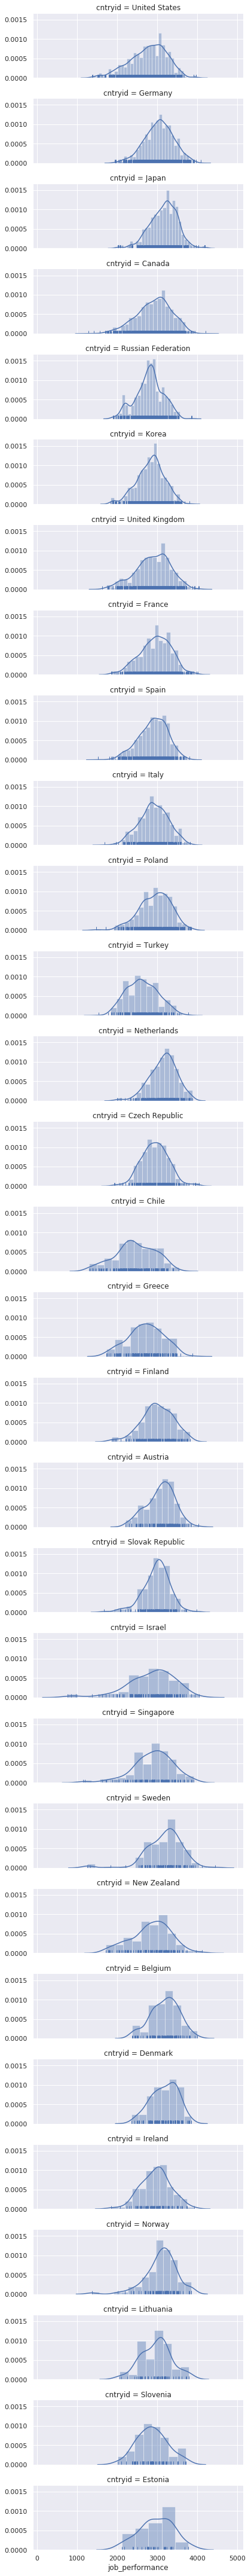

In [0]:
# Distribution plots per categorical variable. Using A facetGrid object with the sns.distplot mapping
# function works a little differently so you will have to specify a things like row_order
categories_list = drop_null_missing_df.cntryid.value_counts().index

g = sns.FacetGrid(drop_null_missing_df, row="cntryid", row_order=categories_list,
                  height=2.0, aspect=3,)
g.map(sns.distplot, "job_performance", hist=True, rug=True);

In [0]:
# groupby country id
grouped = drop_null_missing_df.groupby("cntryid").groups
print(grouped)

{'Austria': Int64Index([  215,   242,   593,   600,   863,  1108,  1172,  1459,  1599,
             1768,
            ...
            19283, 19407, 19513, 19545, 19583, 19722, 19812, 19814, 19871,
            19938],
           dtype='int64', length=186), 'Belgium': Int64Index([   75,   411,   442,   612,   701,   733,   954,   959,  1072,
             1173,
            ...
            18810, 18903, 19030, 19046, 19108, 19148, 19463, 19632, 19701,
            19773],
           dtype='int64', length=143), 'Canada': Int64Index([    0,    22,    41,    72,    95,   110,   113,   115,   130,
              178,
            ...
            19830, 19831, 19884, 19902, 19922, 19929, 19932, 19945, 19964,
            19984],
           dtype='int64', length=1274), 'Chile': Int64Index([   29,   128,   173,   271,   398,   403,   560,   644,   672,
              695,
            ...
            19223, 19316, 19528, 19548, 19566, 19608, 19683, 19891, 19913,
            19924],
           dtype='in

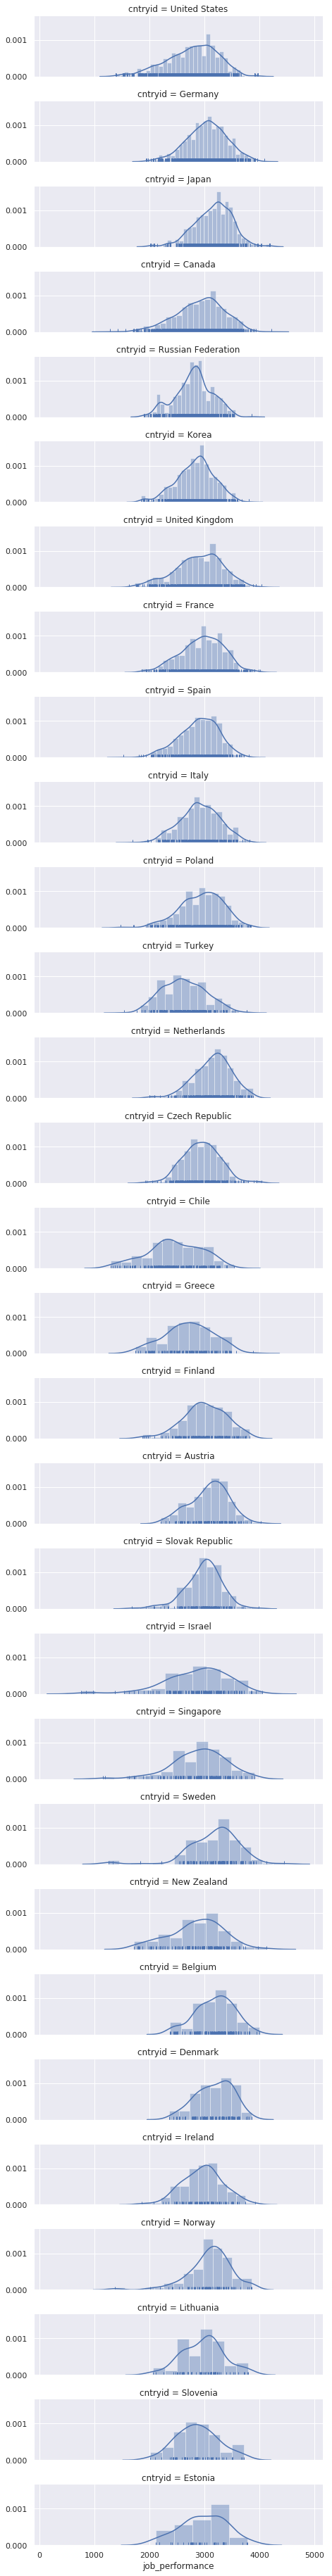

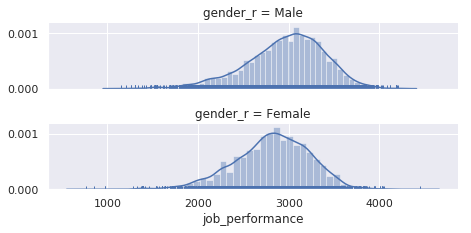

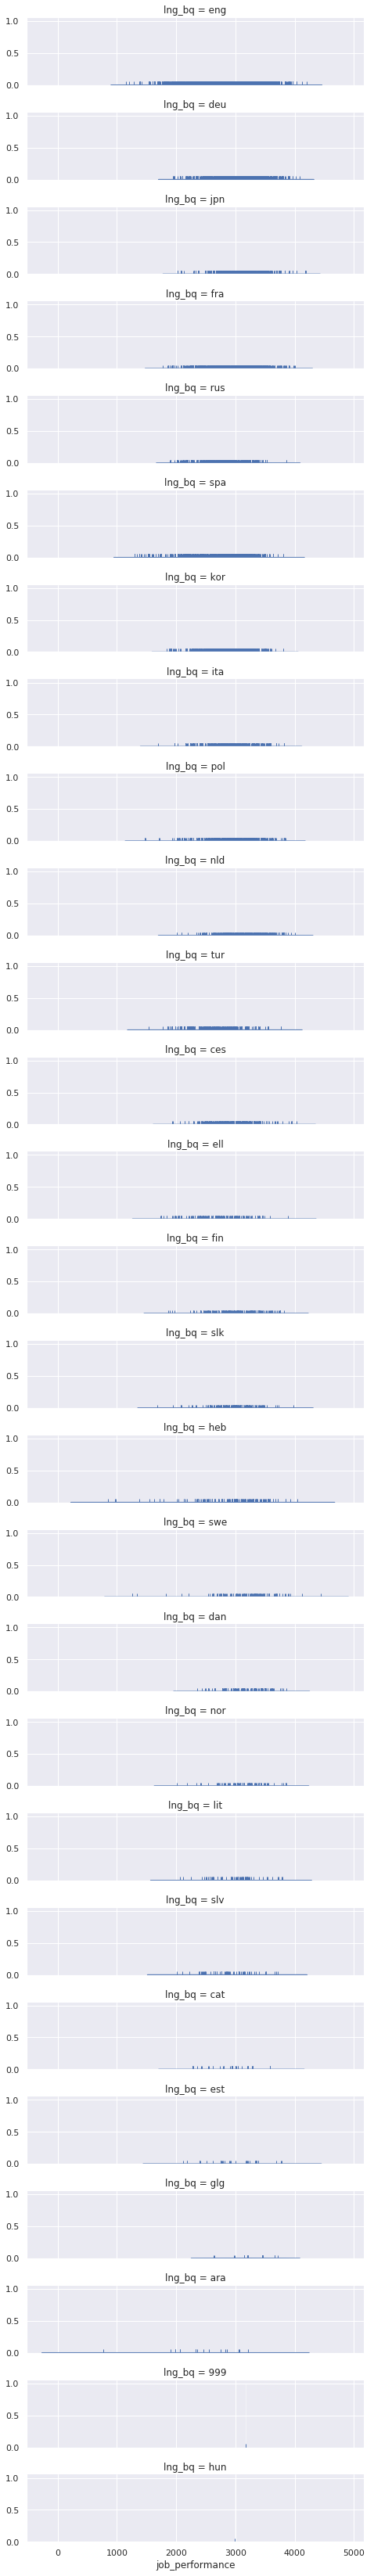

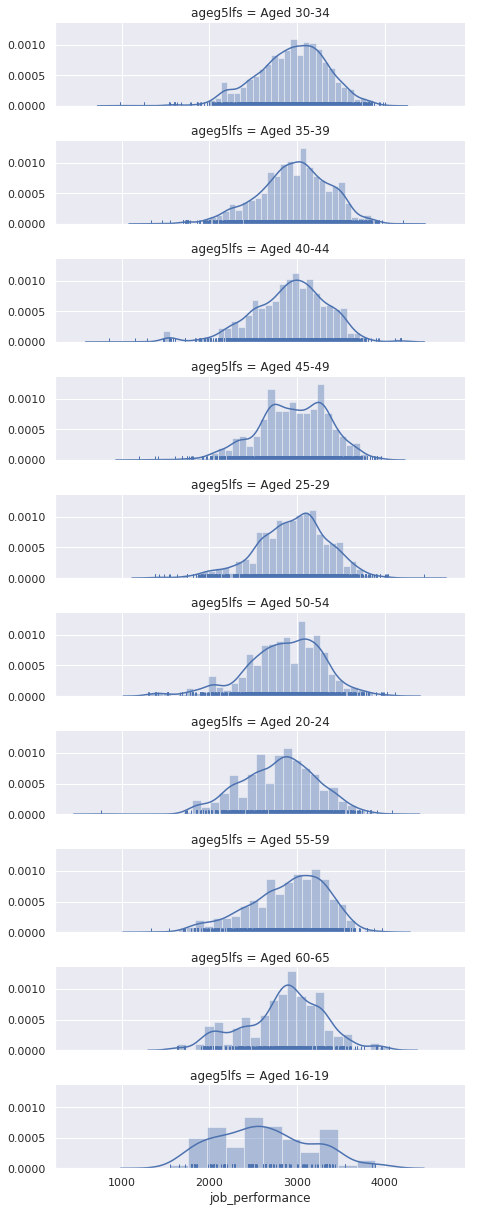

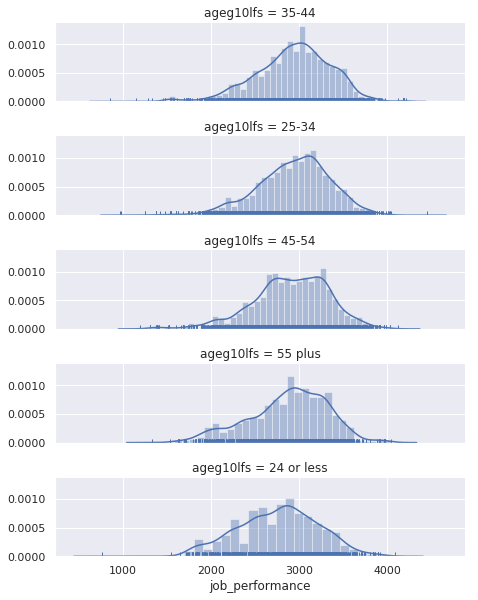

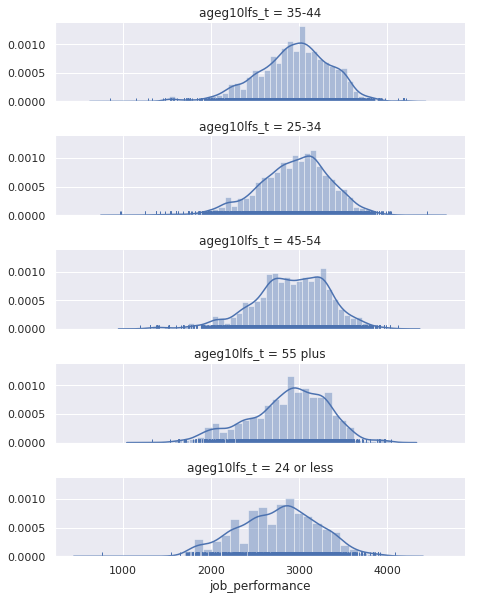

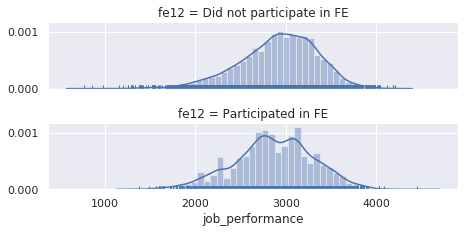

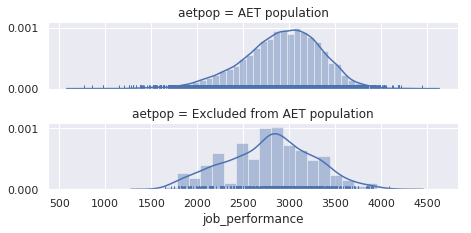

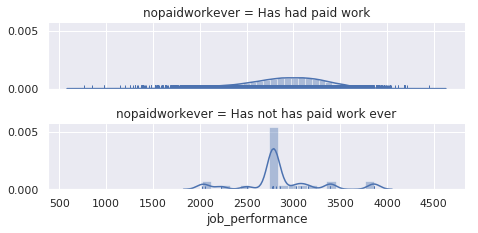

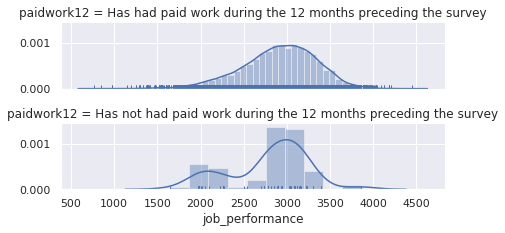

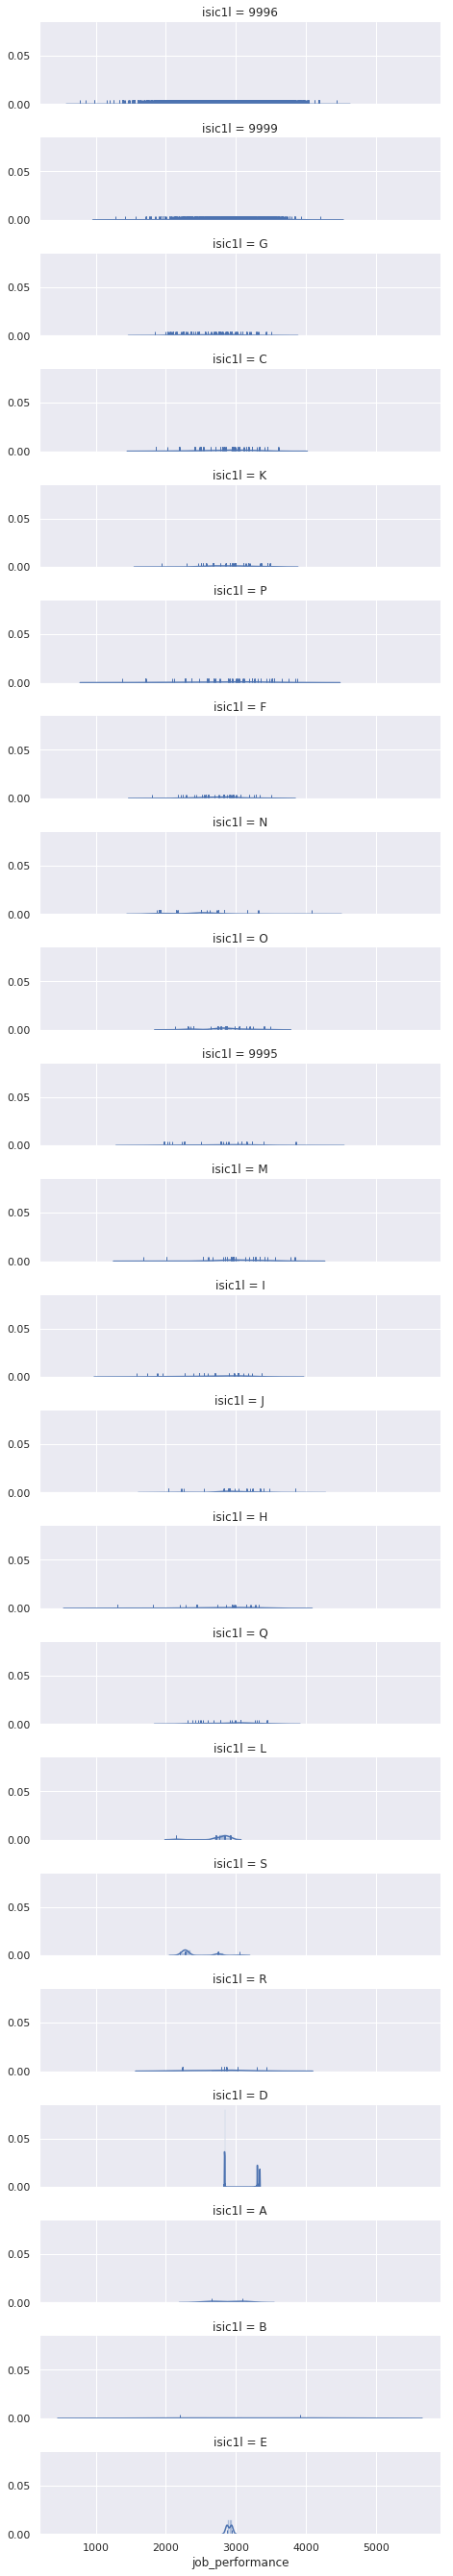

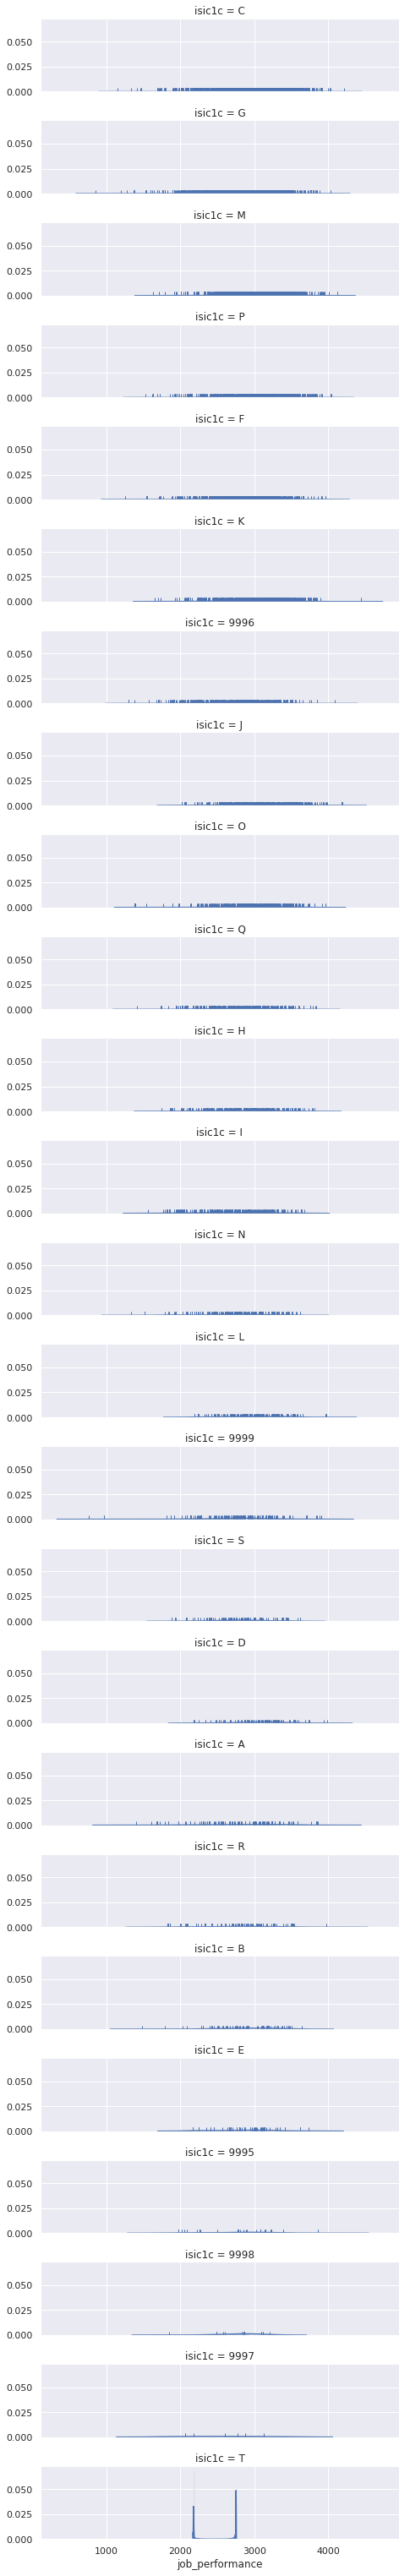

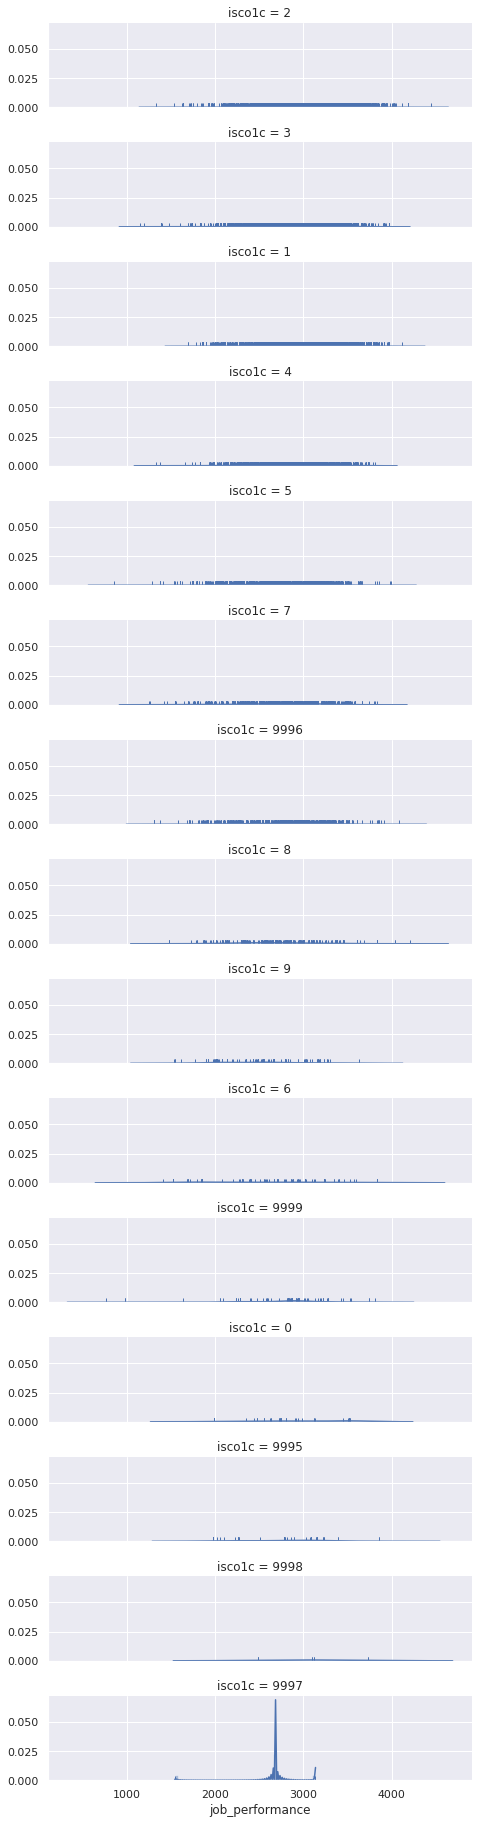

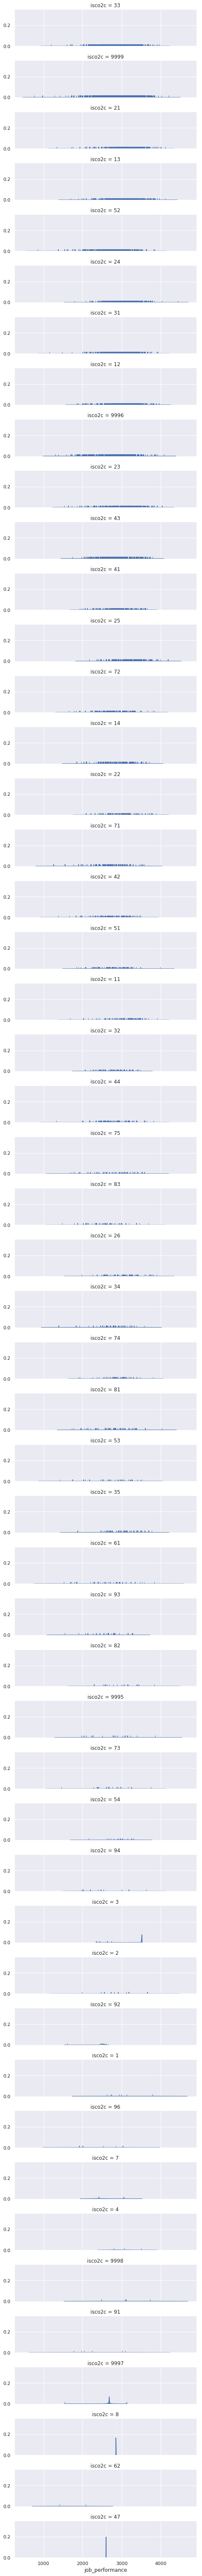

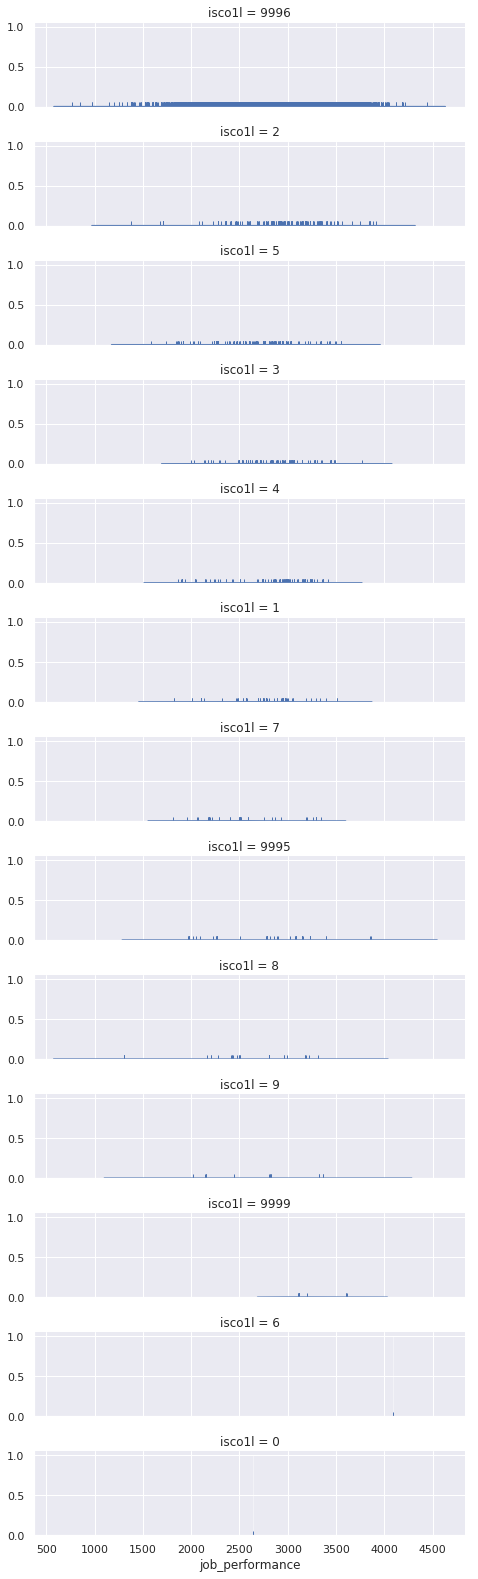

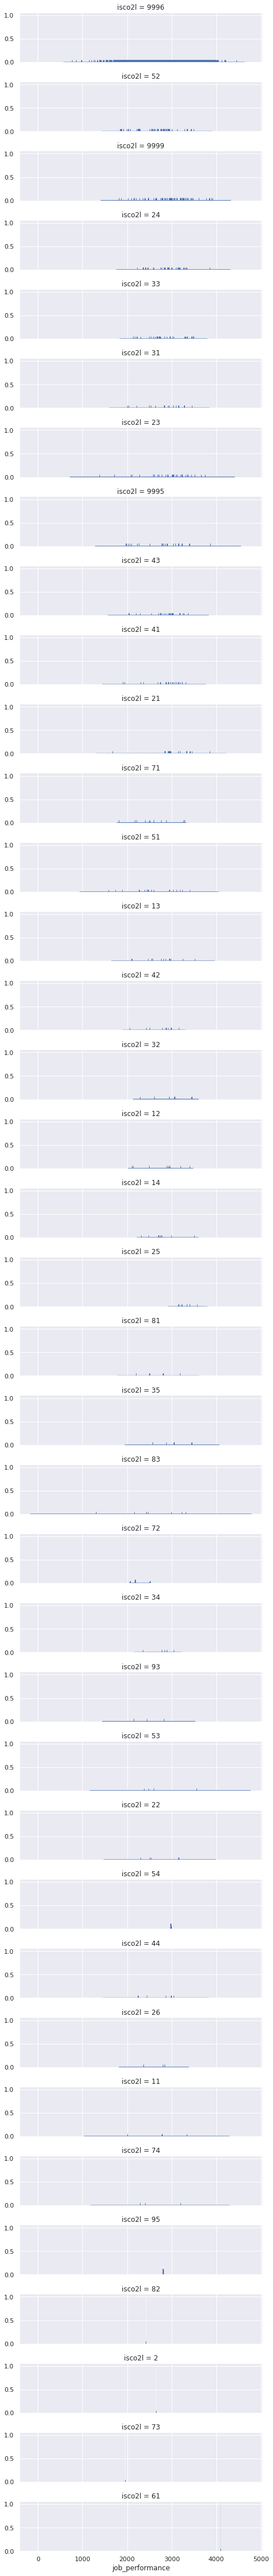

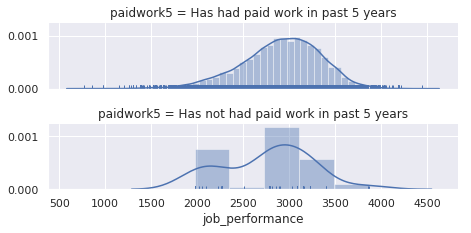

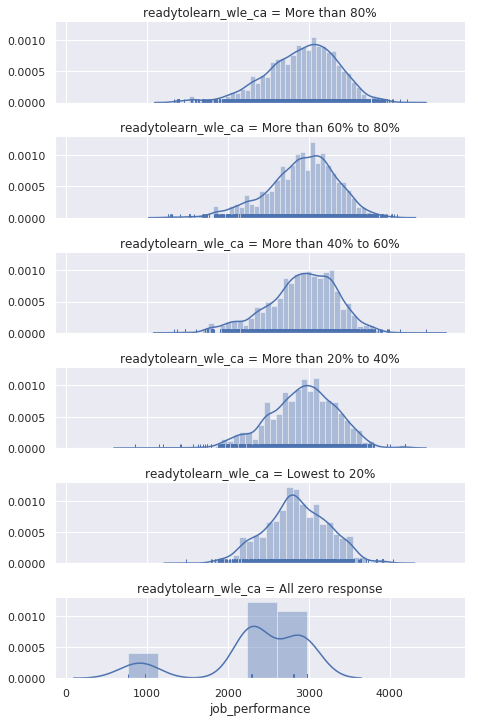

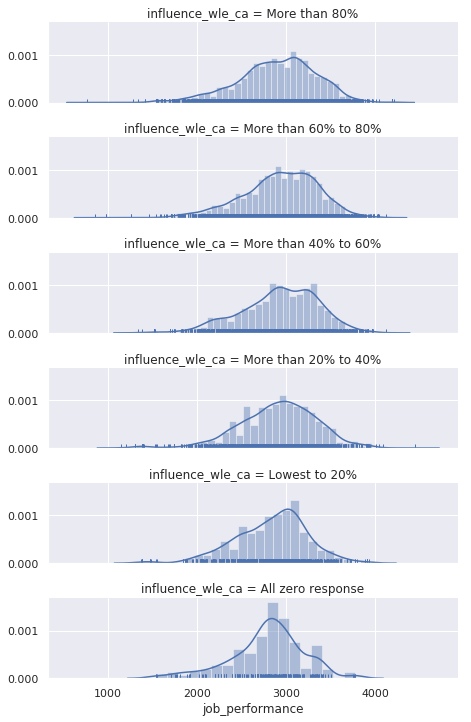

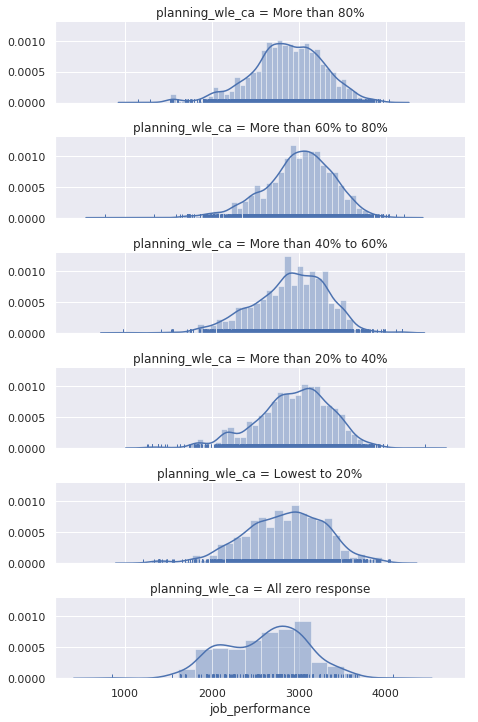

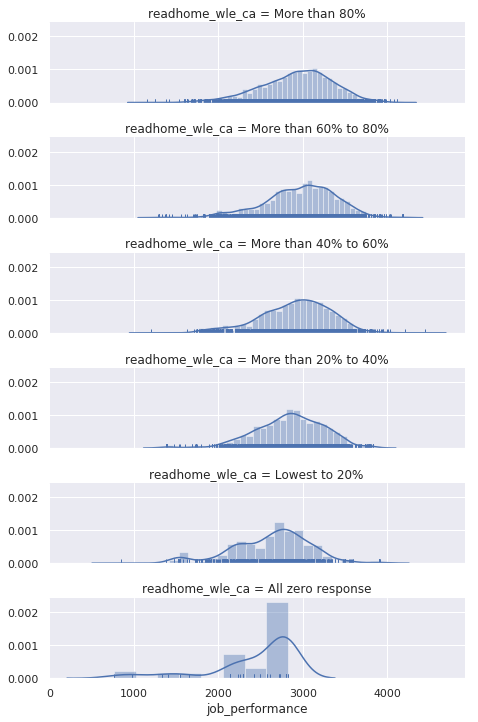

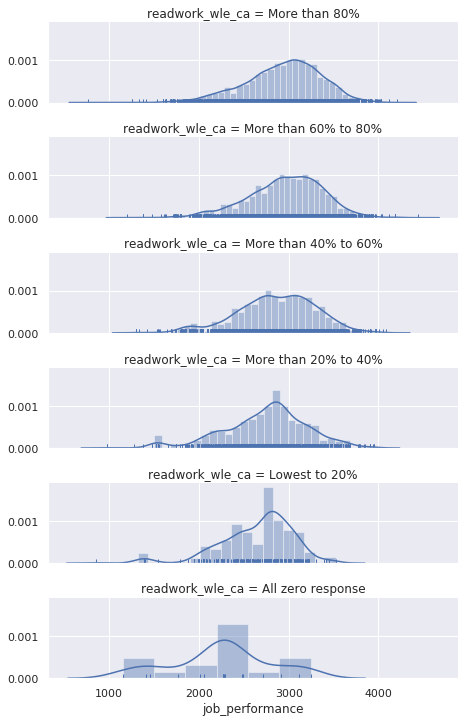

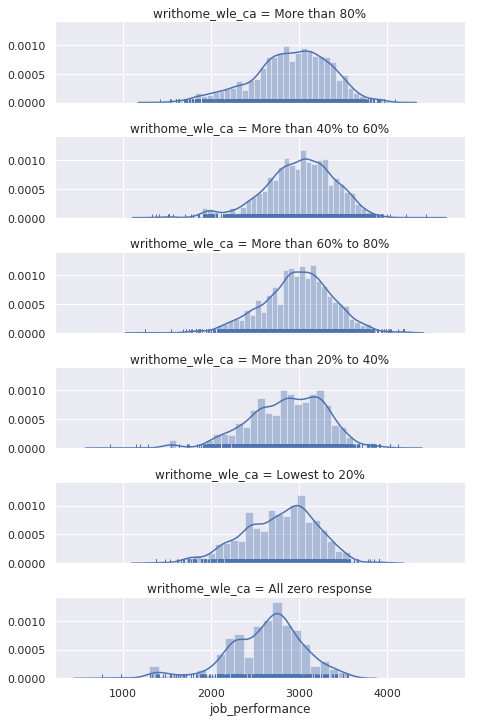

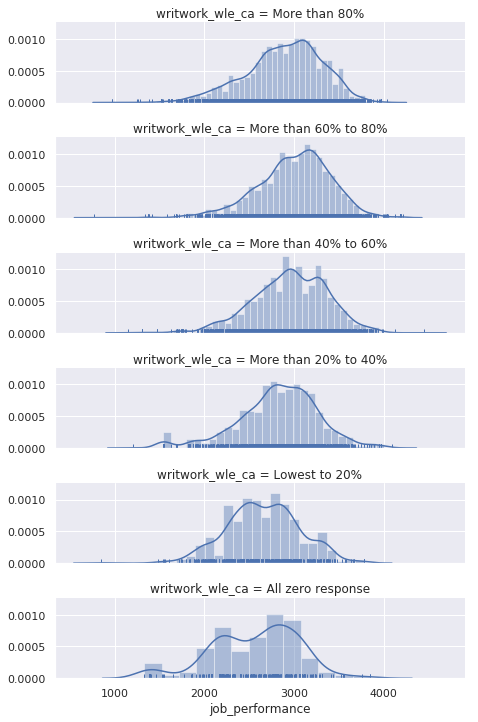

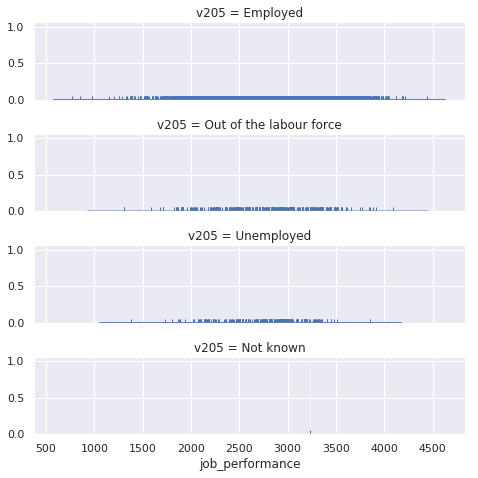

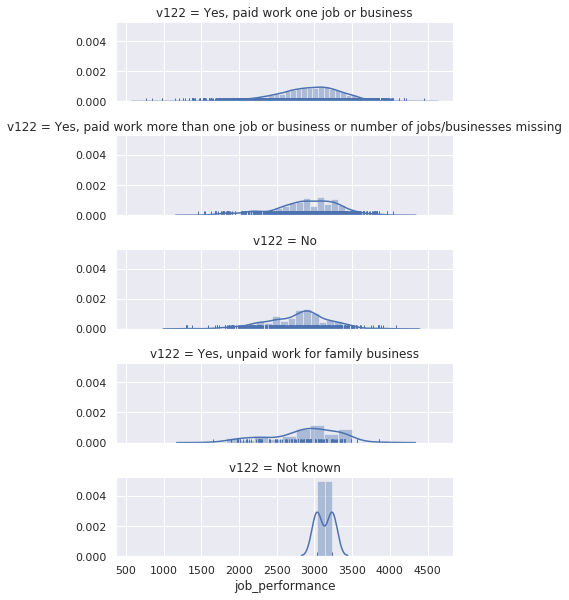

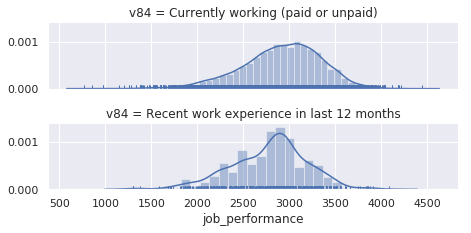

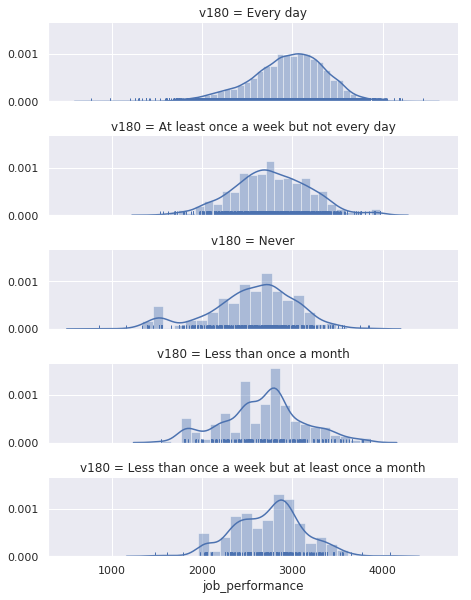

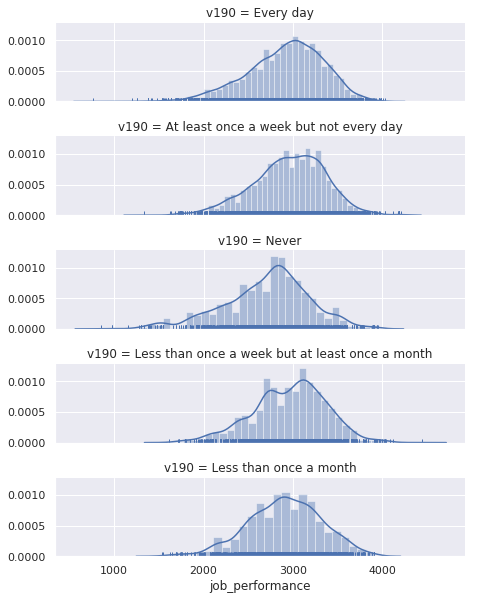

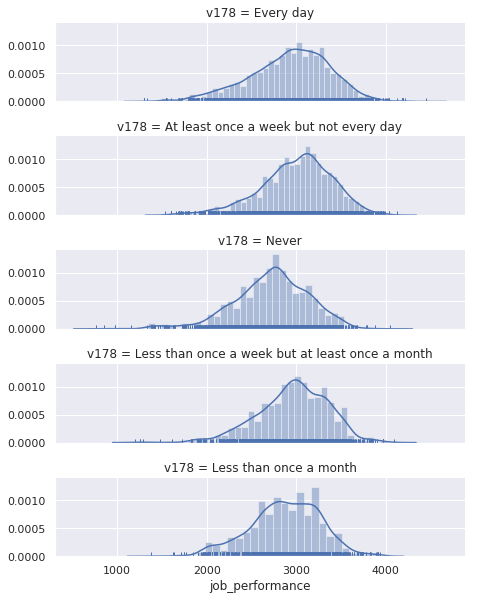

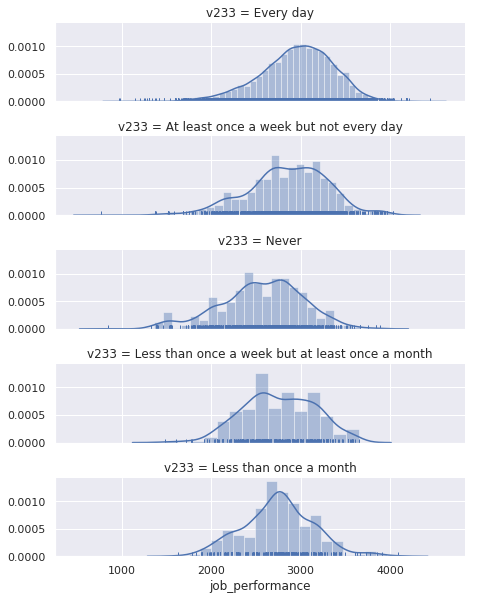

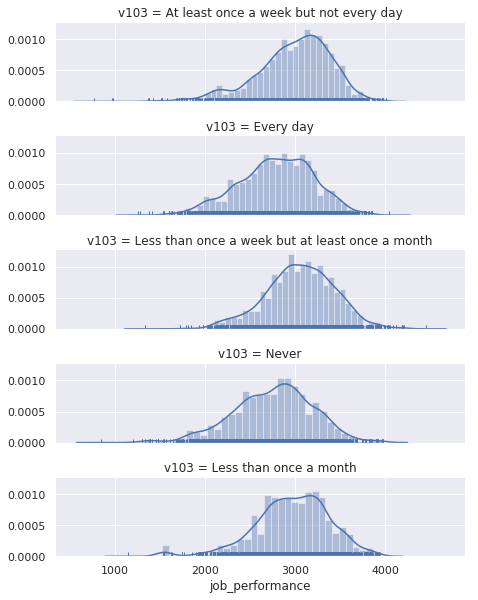

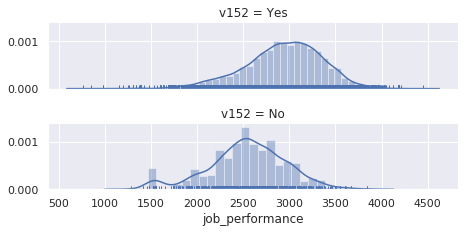

In [0]:
# Plot the facetgrid for every feature against the job_performance metric
for feature in feature_labels:
    cat_list = drop_null_missing_df[feature].value_counts().index
    g = sns.FacetGrid(drop_null_missing_df, row=feature, row_order=cat_list,
                      height=1.7, aspect=4)
    g.map(sns.distplot, "job_performance", hist=True, rug=True);

# Dev Branch 1 - Handling Missing Values - Imputation Step

When we pick an imputation strategy for the our data, we have to consider our data is numeric or non-numeric. We also have to consider whether the variable is nominally categorical or ordinally categorical to determine what type of transformative encoding scheme we can apply to those features.

We also have to consider that the implications that one-hot encoding would have on our tabular dataset when we already have so many features.

## Imputation with a Strategy - EDA

Before we even start imputng, we would want to visually understand the distribution and nature of our missing data.  For example, if the data has seasonality, it would make little sense to impute with a mean value, however - if the data are constant, it may a good idea to impute the missing data value with the mean or median value.

In [0]:
# Plot the missing data features

missing_val_features = [feature for feature in df if df[feature].isnull().sum() != 0]

print("There are {} features with missing values".format(len(missing_val_features)))

for i in missing_val_features:
    print("### {} ###".format(i))
    print(df[i].value_counts())
    print("\n")

There are 344 features with missing values
### cntryid_e ###
United States            4061
Germany                  2061
Japan                    1711
Russian Federation       1210
Korea                    1169
France                   1130
England (UK)             1129
Canada (English)         1079
Spain                     891
Italy                     806
Poland                    768
Turkey                    537
Netherlands               411
Czech Republic            389
Chile                     344
Greece                    208
Finland                   207
Canada (French)           194
Austria                   186
Slovak Republic           184
Israel                    178
Singapore                 156
Sweden                    148
New Zealand               144
Flanders (Belgium)        143
Denmark                   134
Ireland                   112
Norway                     89
Lithuania                  70
Slovenia                   67
Estonia                    43
Northern 

In [0]:
# each element in df.dtypes is the datatype of that feature
print(df[missing_val_features].dtypes[:10]) # i is the string of datatypes

cntryid_e              object
age_r                 float64
computerexperience     object
nativespeaker          object
edlevel3               object
monthlyincpr           object
yearlyincpr            object
lng_home               object
cnt_h                  object
cnt_brth               object
dtype: object


In [0]:
# have a look at the distribution of the missing values in the features that were dropped containing
# missing values

# for feature in missing_val_features:
#     if df[feature].dtype == "object":
#         fig = plt.figure(1, figsize=(8, 14), frameon=False, dpi=100)
#         g = sns.FacetGrid(df, col=feature)
#         g.map(plt.hist, "job_performance", alpha=0.7)

## Univariate Crosstab Analysis

From what we can see, a portion of our data are categorical variables and it will be important to visually explore and visualize using cross tabulation, which is available from the pandas API.

### Cross Tab Frequency Plots of Features that were dropped due to missing values

In [0]:
# # create a cross tabulation for each categorical feature and then plot it
# # These are frequency plots of each of the values that are categorical
# # these plots include the features that were dro

# for feature in missing_val_features:
#     if df[feature].dtype == "object":
#         tabulation = pd.crosstab(index=df[feature], columns="count")
#         tabulation.plot.bar(color="green")

### Cross tab frequency plots of categorical features that did not contain any missing values

In [0]:
# for feature in feature_labels:
#     if drop_null_missing_df[feature].dtype == "object":
#         tabulation = pd.crosstab(index=drop_null_missing_df[feature], columns="count")
#         tabulation.plot.bar(color="purple")

## Bivarate Analysis using Box Plots

In [0]:
# sns.set(style="whitegrid")

# for feature in feature_labels:
#     if drop_null_missing_df[feature].dtype == "object":
#         g = sns.catplot(x=feature, 
#                     y="job_performance", 
#                     data=drop_null_missing_df,
#                     palette="Set2",
#                    kind="box")
#         g.set_xticklabels(rotation=90)

# Dev Branch 1 - Pre-Processing: Encoding Categorical Variables

For simplicity sake, we go with a one hot encoding scheme for our variables, knowing full well that this will lead to a very sparse datset. We will try and not think too hard about this at this time.

In [0]:
features_df = drop_null_missing_df.loc[:, drop_null_missing_df.columns != 'job_performance'] # print(pd.get_dummies(data))

# Separate out the features from the class
dummy_features = pd.get_dummies(drop_null_missing_df.loc[:, drop_null_missing_df.columns != 'job_performance'])
X = dummy_features.values
y = drop_null_missing_df.loc[:, "job_performance"].values

dummy_features = pd.get_dummies(drop_null_missing_df.loc[:, drop_null_missing_df.columns != 'job_performance'])
dummy_features["job_performance"] = y

print("Shape of features dataframe before dummification: {}".format(features_df.shape))
print("Shape of features dataframe after dummification: {}".format(dummy_features.shape))
print("The dataframe has increase {0:.1f}x in feature size after dummification".format(dummy_features.shape[1]/features_df.shape[1]))

Shape of features dataframe before dummification: (20000, 33)
Shape of features dataframe after dummification: (20000, 221)
The dataframe has increase 6.7x in feature size after dummification


In [0]:
# we also need to reset the index
dummy_features = dummy_features.reset_index()
dummy_features = dummy_features.iloc[:, 2:]

Indeed, we are working with a much more sparse dataset after we have assigned dummy variables to the categorical features

In [0]:
# Due to the sheer volume of encodings for these listed columns, we will keep these as typed
# as integers as opposed to the nominal nature of the their encoding

iscolc_columns = ["isco1c", "isco2c", "isco1l", "isco2l"]
for col in iscolc_columns:
    print(f"#### {i} ###")
    print(drop_null_missing_df[col].value_counts()) #remember, value_counts() is a method
    print("\n")

#### v105 ###
2       5059
3       4170
1       3419
4       2089
5       1820
7       1407
9996    1062
8        455
9        160
6        133
9999      90
0         64
9995      56
9998       9
9997       7
Name: isco1c, dtype: int64


#### v105 ###
33      2056
9999    1707
21      1337
13      1225
52      1204
24      1168
31      1151
12      1143
9996    1062
23      1020
43       825
41       561
25       497
72       492
14       420
22       395
71       368
42       348
51       306
11       289
32       270
44       223
75       209
83       193
26       179
34       164
74       163
81       155
53       143
35       127
61       119
93        71
82        63
9995      56
73        46
54        38
94        38
3         32
2         32
92        21
1         19
96        13
7         11
4         10
9998       9
91         8
9997       7
8          3
62         2
47         2
Name: isco2c, dtype: int64


#### v105 ###
9996    18884
2         252
5         250
3         200

 Multiple Correspondence Analysis with the mca package
 
 tetrachoric correlation matrix

# Separate the Features from the Class Variable

## Subsetting the dataset
We are randomly sampling the dataset for  subset that data so that we can  train much faster.

In [0]:
subdf = df.sample(n=int(0.6*df.shape[0]), random_state=123)
subdf.head(2)

,cntryid,cntryid_e,age_r,gender_r,computerexperience,nativespeaker,edlevel3,monthlyincpr,yearlyincpr,lng_home,cnt_h,cnt_brth,reg_tl2,lng_bq,lng_ci,yrsqual,yrsqual_t,yrsget,vet,ctryqual,birthrgn,nativelang,ctryrgn,imyrs,imyrs_c,imyrcat,ageg5lfs,ageg10lfs,ageg10lfs_t,edcat8,edcat7,edcat6,leaver1624,leavedu,fe12,aetpop,faet12,faet12jr,faet12njr,nfe12,...,v253,v132,v284,v267,v260,v26,v171,v14,v7,v240,v186,v162,v149,v228,v28,v237,v280,v175,v288,v15,v208,v43,v27,v114,v191,v170,v65,v57,v177,v69,v85,v50,v89,v127,v239,v224,v71,v105,row,uni
12136,United States,United States,NaN,Male,No,Yes,Medium,50 to less than 75,50 to less than 75,999,NaN,NaN,NaN,eng,eng,12.0,12.0,12.0,False,NaN,NaN,Test language same as native language,North America and Western Europe,NaN,NaN,Non-immigrants,Aged 40-44,35-44,35-44,"Upper secondary (ISCED 3A-B, C long)","Upper secondary (ISCED 3A-B, C long)","Upper secondary (ISCED 3A-B, C long)",NaN,NaN,Did not participate in FE,AET population,Did not participate in formal AET,Did not participate in formal AET for JR reasons,Did not participate in FE for NJR reasons,Did not participate in NFE,...,Never,Never,Never,Never,Never,Never,Never,Less than once a week but at least once a month,Never,Never,Never,Never,Less than once a week but at least once a month,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,To a very high extent,To a very high extent,To a very high extent,To a very high extent,To a very high extent,To a very high extent,Less than once a month,Agree,Agree,Agree,NaN,NaN,9999.0,9996.0,9999,9996.0,13018,cl3770
16812,Chile,Chile,36.0,Female,Yes,Yes,High,50 to less than 75,50 to less than 75,spa,NaN,Chile,CL13,spa,spa,16.0,16.0,16.0,NaN,NaN,Latin America and the Caribbean,Test language same as native language,Latin America and the Caribbean,NaN,NaN,Non-immigrants,Aged 35-39,35-44,35-44,Tertiary – professional degree (ISCED 5B),Tertiary – professional degree (ISCED 5B),Tertiary – professional degree (ISCED 5B),NaN,25.0,Did not participate in FE,AET population,Did not participate in formal AET,Did not participate in formal AET for JR reasons,Did not participate in FE for NJR reasons,Participated in NFE,...,At least once a week,Never,Never,Never,Less than once a month,Rarely,Less than once a month,Less than once a month,Less than once a month,At least once a week but not every day,Never,Never,Never,NaN,Yes,Every day,Every day,Every day,Less than once a month,Less than once a month,Never,Never,To a high extent,To a high extent,To a very high extent,To a high extent,To some extent,To a high extent,Less than once a month,Disagree,Strongly agree,Strongly agree,NaN,NaN,3343.0,9996.0,4100,9996.0,103036,cl3770


## Non-scaled data partitioning

In [0]:
from sklearn.model_selection import train_test_split

# split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.30,random_state=42)

## Standardizing and Normalizing our data

Some of the models we use are sensitive to scaling and perform better with it. Some do not require it.

In [0]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
scaled_X = scaler.fit_transform(X)
scaled_y = scaler.fit_transform(y.reshape(-1,1))

# split into training and testing sets
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(
                                                    scaled_X,
                                                    y,
                                                    test_size=0.30,
                                                    random_state=42
                                                   )

# Dev Branch 1a - Create Null Models

In this block, we will create our null models to build upon. We will be using SVR, Linear Regression, MLPs and simple neural networks to start off.

## Dev Branch 1a -  Simple Linear Regression

In [0]:
# Simple Linear Model

from sklearn.linear_model import LinearRegression

# normalization of your features is not advised here because it makes it hard to interpret 
# the coefficients and they don't normalize well.

lm = LinearRegression(fit_intercept=True, normalize=True, copy_X=True, n_jobs=None)
lm.fit(X_train, y_train)

print("Linear Model Score: {}\n".format(lm.score(X_train, y_train)))
print("Linear Model Coefficient:\n {}\n".format(lm.coef_[:10]))
print("Linear Model Intercept: {}\n".format(lm.intercept_ ))
y_pred = lm.predict(X_test)

Linear Model Score: 0.33490222049791485

Linear Model Coefficient:
 [ 6.28412309e-02 -6.88679049e-02  6.23831685e-02 -4.34893702e-02
  2.43061339e+15 -4.32142031e+15 -2.28878577e+15 -2.28878577e+15
 -3.00019611e+15 -8.68131594e+15]

Linear Model Intercept: 4.060022364914213e+16



In [0]:
inverse_y_pred = scaler.inverse_transform(y_pred)
print("Inverse transform of mse pred\n{}\n".format(inverse_y_pred))

Inverse transform of mse pred
[1324681.10852757 1310983.99757457  968556.22374946 ... 1232225.60959479
 1174012.88804453 1355499.60817183]



## Conclusion
Surprisingly, a high dimensional linear model predicting job performance scores, with default parameters,  returns a relatively high coefficient of determination R2 of 0.33490222049791485, wrt to the number of features.

## Dev Branch 1a - Support Vector Regression

In [0]:
# Support Vector Machine for Regression
from sklearn.svm import SVR
import timeit

svr = SVR(kernel="rbf", degree=3, gamma="auto_deprecated", coef0=0.0, tol=0.001, 
          C=1.0, epsilon=0.1, shrinking=True, cache_size=200, verbose=False, 
          max_iter=-1)

# Using the normalized inputs
start_time = timeit.default_timer()
y_pred = svr.fit(X_train_scaled, y_train)
end_time = timeit.default_timer()
print("Run time: {}".format(end_time - start_time))

print("SVR Model Score: {}\n".format(svr.score(X_train_scaled, y_train)))
print("SVR Model Params:\n {}\n".format(svr.get_params))
y_pred = svr.predict(X_test_scaled)
print("y_pred: \n{}".format(y_pred))
print()

Run time: 86.62639225200002
SVR Model Score: 0.09891703260752771

SVR Model Params:
 <bound method BaseEstimator.get_params of SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
    gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False)>

y_pred: 
[3040.64849753 2965.57895753 2814.49223194 ... 2978.31061388 2931.22179977
 2993.19017607]



## Conclusion
As we can expect from this high dimensional data modelling, we get a terrible R^2 coefficient of determination of the prediction error of 0.09891703260752771

## Dev Branch 1a - Support Vector Regression with Different kernels

In [0]:
svr_rbf = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)
svr_lin = SVR(kernel='linear', C=100, gamma='auto')
svr_poly = SVR(kernel='poly', C=100, gamma='auto', degree=3, epsilon=.1,
               coef0=1)

lw = 2

svrs = [svr_rbf, svr_lin, svr_poly]
kernel_label = ['RBF', 'Linear', 'Polynomial']
model_color = ['m', 'c', 'g']

In [0]:
y_train_scaled

array([3237.92838867, 3134.22077812, 3347.7415722 , ..., 1940.7511306 ,
       2668.03936685, 2802.47217749])

In [0]:
# plot the results
# ig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 10), sharey=True)
# for ix, svr in enumerate(svrs):
#     axes[ix].plot(X_train_scaled, svr.fit(X_train_scaled, y_train_scaled).predict(X_test_scaled), color=model_color[ix], lw=lw,
#                   label='{} model'.format(kernel_label[ix]))
#     axes[ix].scatter(X_train_scaled[svr.support_], 
#                      y_train_scaled[svr.support_], 
#                      facecolor="none", 
#                      edgecolor=model_color[ix], 
#                      s=50, 
#                      label='{} support vectors'.format(kernel_label[ix]))
#     axes[ix].scatter(X_train_scaled[np.setdiff1d(np.arange(len(X_train_scaled)), svr.support_)], 
#                      y_train_scaled[np.setdiff1d(np.arange(len(X_train_scaled)), svr.support_)],
#                      facecolor="none", 
#                      edgecolor="k", s=50,
#                      label='other training data')
#     axes[ix].legend(loc='upper center', bbox_to_anchor=(0.5, 1.1),
#                     ncol=1, fancybox=True, shadow=True)

# fig.text(0.5, 0.04, 'data', ha='center', va='center')
# fig.text(0.06, 0.5, 'target', ha='center', va='center', rotation='vertical')
# fig.suptitle("Support Vector Regression", fontsize=14)
# plt.show()

# 1b - Using Feature Extraction and Factor Analysis

We run multiple null models, after having reduced the number of dimensions and exploring the components of maximum variance from our data.

Assumptions for Factor Analysis

Assumptions:

1. There are no outliers in data.
2. Sample size should be greater than the factor.
3. There should not be perfect multicollinearity.
4. There should not be homoscedasticity between the variables.


Types of Factor Analysis

* Exploratory Factor Analysis: It is the most popular factor analysis approach among social and management researchers. Its basic assumption is that any observed variable is directly associated with any factor.

* Confirmatory Factor Analysis (CFA): Its basic assumption is that each factor is associated with a particular set of observed variables. CFA confirms what is expected on the basic.


## Dev Branch 1b - Simple Linear Regression

In [0]:
# Simple Linear Model

from sklearn.linear_model import LinearRegression

# normalization of your features is not advised here because it makes it hard to interpret 
# the coefficients and they don't normalize well.

lm = LinearRegression(fit_intercept=True, normalize=True, copy_X=True, n_jobs=None)
lm.fit(X_train, y_train)

print("Linear Model Score: {}\n".format(lm.score(X_train, y_train)))
print("Linear Model Coefficient:\n {}\n".format(lm.coef_))
print("Linear Model Intercept: {}\n".format(lm.intercept_ ))
y_pred = lm.predict(X_test)

## Plot SLR model performance

In [0]:
# plt.scatter(X_train, y_train)
# plt.plot(np.sort(X_test, axis=0),y_pred)
# plt.show()

## Dev Branch 1b -  Support Vector Regression

In [0]:
# Support Vector Machine for Regression
from sklearn.svm import SVR
import timeit

svr = SVR(kernel="rbf", degree=3, gamma="auto_deprecated", coef0=0.0, tol=0.001, 
          C=1.0, epsilon=0.1, shrinking=True, cache_size=200, verbose=False, 
          max_iter=-1)

# X_train_scaled
start_time = timeit.default_timer()
y_pred = svr.fit(X_train, y_train)
end_time = timeit.default_timer()
print("Run time: {}".format(end_time - start_time))

print("SVR Model Score: {}\n".format(svr.score(X_train, y_train)))
print("SVR Model Params:\n {}\n".format(svr.get_params))
y_pred = svr.predict(X_test)
print("y_pred: \n{}".format(y_pred))

## Plot SVR model performance

In [0]:
fig = plt.figure()
plt.show()

In [0]:
# !pip install tpot

## Dev Branch 1b -TPOT Model Performance

Teapot does hyperparameter tuning, model selection and preprocessing all in one pipeline. It takes a while to train the say the least. We will select the best parameter from training on the null dataset (without any feature engineering) to see if we can get a functioning model from this exercise

In [0]:
import timeit
from tpot import TPOTClassifier
from sklearn.metrics import (
    confusion_matrix,
    roc_auc_score,
    precision_recall_fscore_support,
    accuracy_score,
)
from pprint import pprint


tpot = TPOTClassifier(generations=5, population_size=50, verbosity=2, n_jobs=-1)

prec_rec_fsc_sup = ["precision", "recall", "fscore", "support"]

start_time = timeit.default_timer()
tpot.fit(X_train, y_train)
y_pred = tpot.predict(X_test)
end_time = timeit.default_timer()
runtime = end_time - start_time
print(f"Total runtime for the {name} dataset: {runtime}s")


print("\nConfusion Matrix for the {} dataset\n{}\n".format(confusion_matrix(name, y_test, y_pred)))

print("Precision/Recall/FScore/Support for the {} dataset".format(name))
for met, val in zip(prec_rec_fsc_sup, precision_recall_fscore_support(y_test, y_pred)):
    pprint("{}: {}".format(met, val))

print("Accuracy score for the {} dataset: {}".format(name, accuracy_score(y_test, y_pred)))


# Best Performing Models
1. LinearSVC
Best pipeline: LinearSVC(PolynomialFeatures(input_matrix, degree=2, include_bias=False, interaction_only=False), C=20.0, dual=False, loss=squared_hinge, penalty=l2, tol=0.1)
Total runtime: 45.1908969899996s
Average Accuracy Score: 0.9666666666666667
Best Accuracy Score: 0.9825757575757577

2. 

# Wine Dataset
1. GradientBoostingClassifier
Best pipeline: GradientBoostingClassifier(input_matrix, learning_rate=0.5, max_depth=3, max_features=0.1, min_samples_leaf=1, min_samples_split=4, n_estimators=100, subsample=0.6500000000000001)
Total runtime: 63.685036884999136s
Average Accuracy Score: 0.9722222222222222
Best Accuracy Score: 0.9928571428571429


# Hyperparameter Tuning

After a while, you start getting an intuition of which hyperparameters are more important than others.

In [0]:
grid search, beam search, bayesian optimization, random search

The most successful people are the most effective communicators of results and your visualizations, and why your work matters and what you found

# Things to do for next week

combine all the models into a single classifier
weighted stacking of models
you can learn this weighting through meta weighting

boosting is usually based on weak sequential classifiers
this deals with hard edge cases with weak classifiers

learn about about whether your model is over fitting
to plot, save the RMSE, for each model, and then plot them on a line chart
per epoch to see how the different models faired in terms of the number of 
accuracy vs epochs

Also useful for plotting the effects of differnt settings fo different hyperparameters on performance using parallel coordinates

experiment managers, such as Sacred, build your own tools for your own experiments. 

keep iterating model development

Finally, think about how do you deploy this model.
Deploy this with client facing user input through an app.

How do you display this projec tot someone and make it look nice. 

Simple interface so that they can get predictions for the model. Think about the context , what the model does. 
Existing tools exist. Think about simple servers, where a user will serve a request, run the model, and then serve the prediction. Just in the http request. You don't even have an interface, you can just have a simple API

read about how models get deployed at inference time. Look at AWS EC2 and lambda. How do you deal with data. do you persist those user requests, and things like.
Read into flask.

set up a siimple server that can handle requests. How to launch an ec2 (hosting servers) instqance and how to store data in an s3 bucket. Dynamo for databases. Lambda for inference that is adaptable.

GCP, AWS. server.

Think about presentation.